NOTE: You can run this code from the section 3 Network. We provided the *.csv file with hashed names. We left 1 Importing Data and 2 Cleaning sections just to preview the code.

# 1. Importing Data

# install drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

# import data

additionally cleaning, dropping columns, changing names to lowercase, ignoring white space, etc.

In [3]:
PATH = '/content/drive/MyDrive/cogsci/cpm2/PROJECT-cpm2/CPM II project_uzupelnione_osoby_230610_CPM II project_cleaned-2.csv'
PATH_ADA = 'https://drive.google.com/drive/folders/1eS3URqruZLLuRxDitGbn5jJbgwMGce-T?usp=drive_link'

In [4]:
df = pd.read_csv(PATH)

In [ ]:
df.head()

In [6]:
# drop unimportant columns
df = df.drop(labels=['StartDate', 'EndDate', 'Status', 'IPAddress', 'Progress',
       'Duration (in seconds)', 'Finished', 'RecordedDate', 'ResponseId',
       'RecipientLastName', 'RecipientFirstName', 'RecipientEmail',
       'ExternalReference', 'LocationLatitude', 'LocationLongitude',
       'DistributionChannel', 'UserLanguage'], axis=1)

In [7]:
# change column names
df.columns = ['consent','person', 'year', 'bachelor', 'language', 'contacts', 'communication', 'additional_communication']

In [8]:
# delete drop the first row with not important information
df = df.drop(index=1)

In [9]:
# drop a row for the questions in questionnaire
df = df.drop([0])

In [10]:
df = df.reset_index(drop=True)

In [11]:
# save original dataframe
df_original = df

In [ ]:
# this is a person with a NaN value, so I will drop it
df.iloc[25]

In [14]:
# drop the the person who didnt fill the name column
df = df.drop(index=25).reset_index(drop=True)

# 2. Cleaning

# lowercase, unicode, no white spaces etc.
Preprocess the contact lists: Before comparing the contact lists, preprocess the data by standardizing the names. Convert all names to lowercase, remove leading and trailing spaces, and eliminate unnecessary punctuation. This step ensures consistency in the data.

In [15]:
!pip install unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 10.8 MB/s eta 0:00:00


In [16]:
from unidecode import unidecode

1. Contacts

In [ ]:
df.iloc[:]['contacts']

In [18]:
df_transformed = [unidecode(contact.lower().replace('\n',',').replace(" ", "").replace("-", ",")) for contact in df.iloc[:]['contacts'] if type(contact) == str]

In [19]:
df['contacts'] = df_transformed

In [ ]:
df['contacts']

In [ ]:
df['person']

In [21]:
person_transformed = [unidecode(contact.lower().replace(" ", "")) for contact in df.iloc[:]['person']]

In [23]:
df['person'] = person_transformed

In [ ]:
df['person']

## additional transformations

Making the list inside the column "contacts"

In [ ]:
df.loc[:,'contacts'] = [row.split(',') for row in df[:]['contacts']]

In [ ]:
df.loc[:,'contacts']

## for hashing:

In [27]:
# exploding 'contacts'column create a separate row for each list instance
df_exploded = df.explode('contacts')

In [ ]:
df_exploded

In [29]:
# resetting index of the dataframe
df_exploded = df_exploded.reset_index(drop=True)

In [30]:
# There is a row with an empty string in 'contacts' column, which later causes problems, so we need to delete it
df_exploded[df_exploded['contacts'] == ''].index

Int64Index([76], dtype='int64')

In [ ]:
df_exploded.iloc[76]

In [32]:
df_exploded = df_exploded.drop(index=76).reset_index(drop=True)

In [33]:
# Check for more empty strings
df_exploded[df_exploded['person'] == ''].index

Int64Index([], dtype='int64')

## preprocessing: HASHING

One of the most commonly used hashing algorithms is the SHA-256 (Secure Hash Algorithm 256-bit). It belongs to the SHA-2 family of hash functions and generates a 256-bit hash value.

Shorter hash code: the md5 algorithm. MD5 is considered to be a weak cryptographic hash function and is not recommended for security-related purposes.


In [34]:
import hashlib

In [35]:
def hash_string(input_string):
    # Create an MD5 hash object
    md5_hash = hashlib.md5()

    # Convert the input string to bytes and hash it
    md5_hash.update(input_string.encode('utf-8'))

    # Get the hexadecimal representation of the hash value
    hashed_string = md5_hash.hexdigest()

    # Get the first 6 characters of the hash
    shortened_hashed_string = hashed_string[:6]

    return shortened_hashed_string

# Example usage
input_string = "Hello, World!"
hashed_string = hash_string(input_string)

print(f"Input string: {input_string}")
print(f"Hashed string (shortened): {hashed_string}")

Input string: Hello, World!
Hashed string (shortened): 65a8e2


In [ ]:
df_exploded.iloc[:]['contacts']

# creating library of all names

In [37]:
library_names = df_exploded['contacts'].append(df['person'], ignore_index=True)

<ipython-input-37-f5b1f8c21906>:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  library_names = df_exploded['contacts'].append(df['person'], ignore_index=True)


In [ ]:
library_names.value_counts()

In [39]:
# we want delete duplicates
library_names = library_names.drop_duplicates()

In [ ]:
library_names.value_counts()

In [41]:
library_names = library_names.reset_index(drop=True)

In [42]:
# Series into the DataFrame
library_names = library_names.to_frame(name='person')

# Resetting the index
library_names = library_names.reset_index(drop=True)

In [43]:
#hashing the names
library_names['hashed'] = library_names['person'].apply(lambda x: hash_string(x))

In [ ]:
library_names

In [ ]:
len(library_names['hashed'].unique())

44

# Hashed library
Now the names in copied dataframe have to be transformed into hashed forms, which will be assigned from the created dictionary

In [45]:
# Library_names has to be transformed into dictionary:
dictionary_names = dict(zip(library_names['person'], library_names['hashed']))

In [ ]:
dictionary_names

duplicate original dataframe

In [47]:
# duplicating original daframe
df_hashed = df

In [48]:
# replacing names with hash in the column of a person who filled the questionnaire
df_hashed['person'] = df_hashed['person'].map(dictionary_names)

In [ ]:
df_hashed['person']

In [50]:
# function to replace name with hash from hash-dictionary
def replace_with_hashes(name_list):
    return [dictionary_names.get(name, name) for name in name_list]

In [51]:
# applying hashing function to a column of contacts - each row contains a list, that's why we need a function
df_hashed['contacts'] = df_hashed['contacts'].apply(replace_with_hashes)

In [ ]:
df_hashed['contacts']

Final Dataframe with hashed names

In [53]:
df_hashed.columns

Index(['consent', 'person', 'year', 'bachelor', 'language', 'contacts',
       'communication', 'additional_communication'],
      dtype='object')

In [54]:
# check if person is in cleaned_contacts
for index, row in df_hashed.iterrows():
    if type(row['person']) == float:
      pass
    else:
      for contact in row['contacts']:
        if (row['person'] == contact):
          print(index)
          print(row['person'])
          print(contact)
        else:
          pass


In [62]:
#df_hashed.to_csv('CPM2_230630_hashed_data.csv', index=False)

# 3. Network

# 3 Network -> note: this part you can run with provided *.csv file

In [55]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Visualizing the network

[1st example with the code](https://towardsdatascience.com/from-dataframe-to-network-graph-bbb35c8ab675)

[2nd example with the code](https://www.google.com/search?q=how+dataframe+wfor+networkx+should+look+like&oq=how+dataframe+wfor+networkx+should+look+like&aqs=chrome..69i57j33i160.11784j0j7&sourceid=chrome&ie=UTF-8)

To run below code, PATH of the file: 'CPM2_230630_hashed_data' needs to be specified

In [65]:
# change the path!
# PATH = '/content/CPM2_230630_hashed_data.csv'
PATH = # TO DO

In [66]:
df_hashed = pd.read_csv(PATH)

In [71]:
df_hashed = df_hashed.drop(labels='Unnamed: 0', axis = 1)

In [72]:
df_hashed.columns

Index(['consent', 'person', 'year', 'bachelor', 'language', 'contacts',
       'communication', 'additional_communication'],
      dtype='object')

In [73]:
df_hashed['contacts']

0     ['656532', 'a1aadf', '0a5219', '202d9f', '2470...
1     ['34674a', '49bf21', 'ab5e9a', '5ea7c8', 'ea9a...
2     ['a11cd8', 'ab5e9a', '49bf21', '0a5219', '202d...
3     ['34674a', 'a11cd8', 'd6dd1f', '49bf21', '89c3...
4     ['64ce90', 'cc548f', 'e5df29', '58a2a8', 'ab5e...
5     ['683466', '25e301', '202d9f', 'd9b543', 'a1aa...
6     ['0a5219', 'be7326', '58a2a8', '247038', '4f6d...
7     ['732ccc', '64ce90', 'cc548f', '25e301', '202d...
8     ['25e301', 'cc548f', '247038', '58a2a8', '49bf...
9     ['cc548f', '247038', 'be7326', '202d9f', '25e3...
10             ['34674a', 'a210f8', 'a11cd8', '3e9754']
11    ['683466', '25e301', '202d9f', 'd9b543', 'a1aa...
12    ['ab5e9a', '34674a', 'ea9a55', '5ea7c8', '6bc1...
13    ['ce8fcd', '732ccc', '5ea7c8', 'a11cd8', 'b4f4...
14    ['656532', '683466', 'af0ed3', '202d9f', 'a1aa...
15    ['202d9f', '732ccc', 'ab5e9a', 'd9b543', '6834...
16                       ['34674a', '89c3b5', '0647cf']
17    ['58a2a8', 'acf59e', '202d9f', '0647cf', '

In [74]:
# coping dataframe
df_edges = pd.DataFrame(df_hashed)

# exploding the 'contacts' column to create separate rows for each contact
df_edges_exploded = df_edges.explode('contacts')

# dropping index
df_edges_exploded = df_edges_exploded.reset_index(drop=True)

# rename columns
df_edges_exploded.columns = ['consent', 'person', 'year', 'bachelor', 'language', 'contacts',
       'communication', 'additional_communication']

In [75]:
G = nx.Graph()
G = nx.from_pandas_edgelist(df_edges_exploded, source='person', target='contacts')

Spring layout

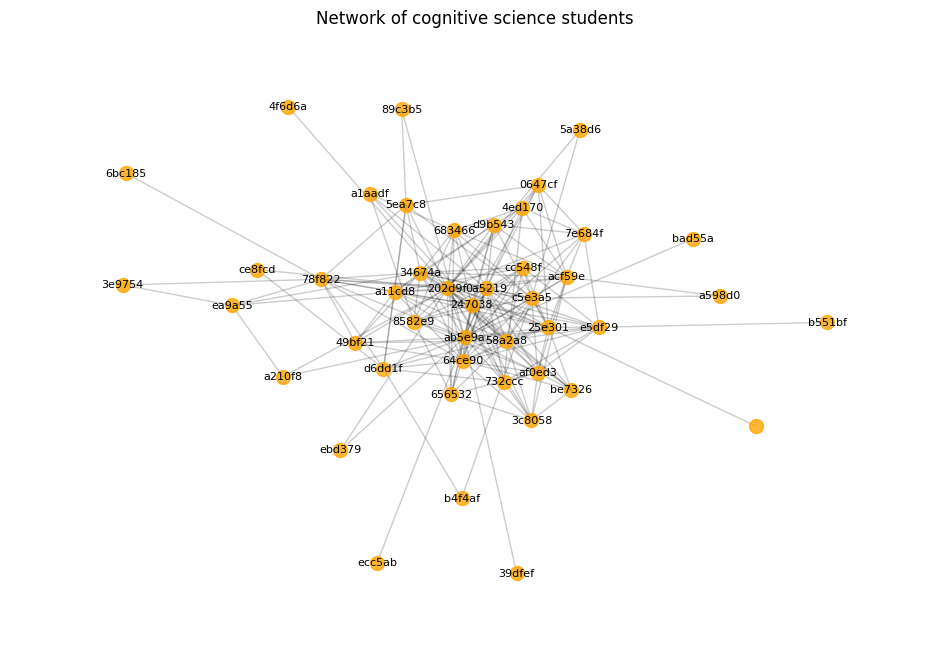

In [ ]:
pos = nx.spring_layout(G)

plt.figure(figsize=(12, 8))
# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color='orange', node_size=100, alpha=0.8)
# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.2)

nx.draw_networkx_labels(G, pos, font_size=8)

plt.title("Network of cognitive science students")

# remove a frame
plt.axis('off')

# Adjust plot margins
plt.margins(0.1, 0.1)

plt.show()

kamada_kawai_layout - I think looks promising



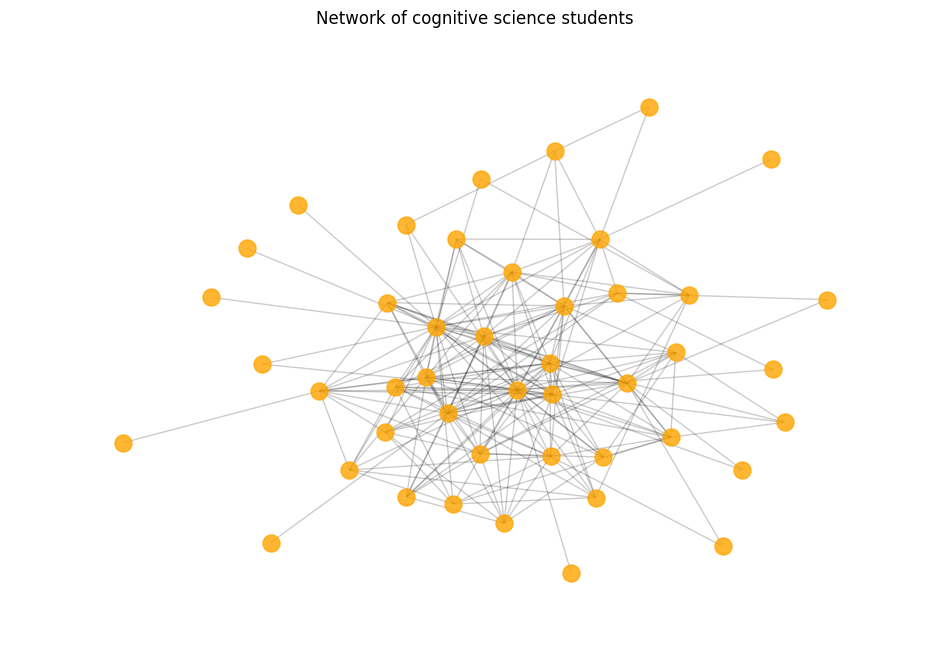

In [ ]:
pos = nx.kamada_kawai_layout(G)

plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G, pos, node_color='orange', node_size=150, alpha=0.8)
# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.2)

plt.title("Network of cognitive science students")

# remove a frame
plt.axis('off')

# Adjust plot margins
plt.margins(0.1, 0.1)

plt.show()

Shell layout

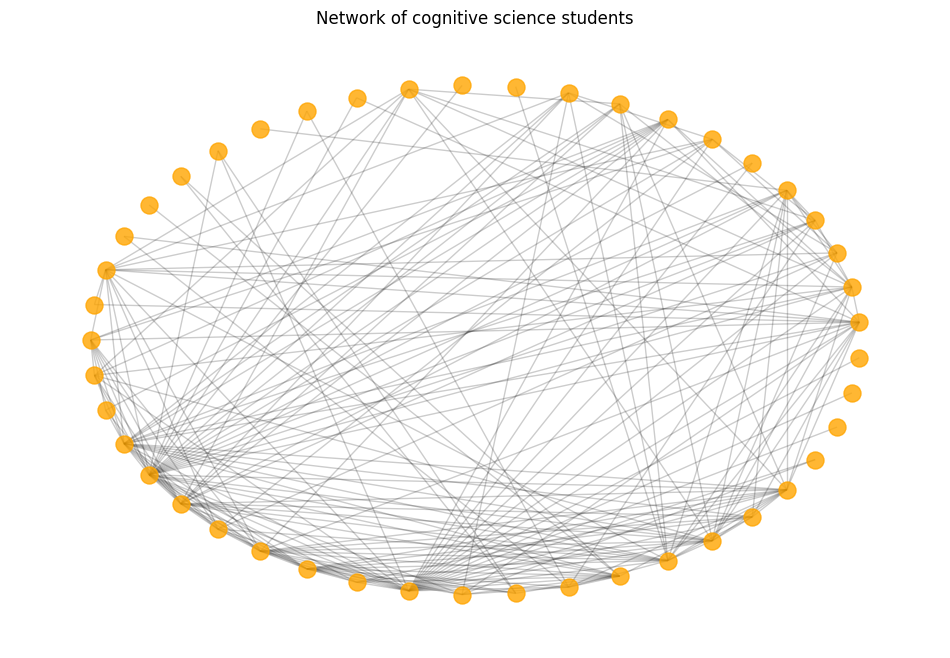

In [ ]:
pos = nx.shell_layout(G)

plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G, pos, node_color='orange', node_size=150, alpha=0.8)
# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.2)

# remove a frame
plt.axis('off')

plt.title("Network of cognitive science students")
plt.show()

## Analysis

# 1. Density

The ratio of actual edges in the network to all possible edges in the network. A density value close to 1 indicates a highly connected network, while a value close to 0 indicates a sparsely connected network.

This network's value is 0.20 so it is not highly connected. This may also indicates that there are nodes which are quite isolated from very interconnected nodes of the network.

In [ ]:
density = nx.density(G)
print("Network density:", density)

Network density: 0.2080808080808081


# 2. Clustering coefficient

The clustering coefficient measures the degree to which nodes in a network tend to cluster or form tightly interconnected groups. It provides insights into the local connectivity patterns within the network.

The clustering coefficient is a measure of how interconnected or clustered the nodes in a network are. It quantifies the degree to which nodes in a network tend to form clusters or groups.

In social networks, the clustering coefficient can provide insights into the presence of social cohesion or cliques. It measures the likelihood that two neighbors of a node are also connected to each other. A higher clustering coefficient indicates a higher tendency for nodes to form clusters and for connections to be present among neighbors.

In [ ]:
# Calculate the clustering coefficient for each node
node_clustering = nx.clustering(G)

# Compute the average clustering coefficient for the network
average_clustering = nx.average_clustering(G)

# Print the clustering coefficient for each node
# for node, clustering_coefficient in node_clustering.items():
#     print(f"Node {node}: Clustering Coefficient = {clustering_coefficient}")

print(f"Average Clustering Coefficient: {average_clustering}")

Average Clustering Coefficient: 0.4912577570291412


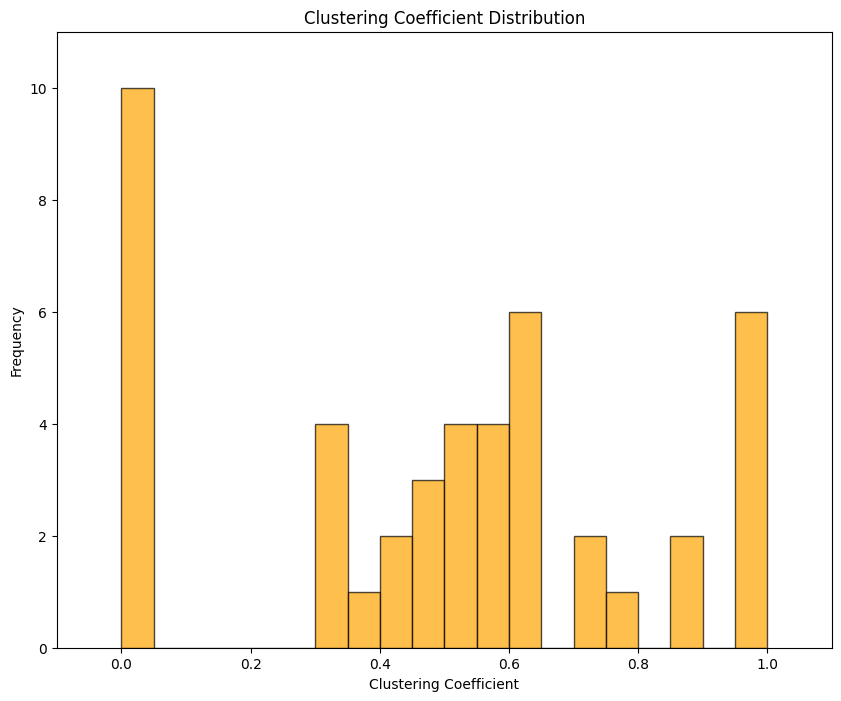

In [ ]:
# Get the clustering coefficients as a list
clustering_coefficients = list(node_clustering.values())

plt.figure(figsize=(10, 8))

# Plot the histogram
plt.hist(clustering_coefficients, bins=20, alpha=0.7, color='orange', edgecolor='black')

plt.xlabel('Clustering Coefficient')
plt.ylabel('Frequency')


# Adjust plot margins
plt.margins(0.1, 0.1)

plt.title('Clustering Coefficient Distribution')
plt.show()

 An average clustering coefficient of 0.40 indicates a relatively high level of clustering or local connectivity in the network. On average 40% of possible connections between the neigbhors of a node are present in the network. Overall, it means a tendency for the nodes to form tightly interconnected clusters.

Transitivity is the structural measure. It shows how innterconnected a graphs in in terms of a ratio of actual possible connections. Transitivity is the ratio of all triangles over all possible triangles. A possible triangle exists when one person knows two people.

In [ ]:
triadic_closure = nx.transitivity(G)
print("Triadic closure:", triadic_closure)

Triadic closure: 0.4934346924671735


# 3. degree distribution of a network

Degree distribution refers to the probability distribution of the degrees (number of connections) of nodes in a network.




In [ ]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
average_degree = sum(dict(G.degree()).values()) / num_nodes

print("Number of nodes:", num_nodes)
print("Number of edges:", num_edges)
print("Average degree:", average_degree)


Number of nodes: 45
Number of edges: 206
Average degree: 9.155555555555555


Number of nodes: 45
Number of edges: 203
Average degree is the average number of connections per node in the network. In this network each individual has approximately 9 contacts

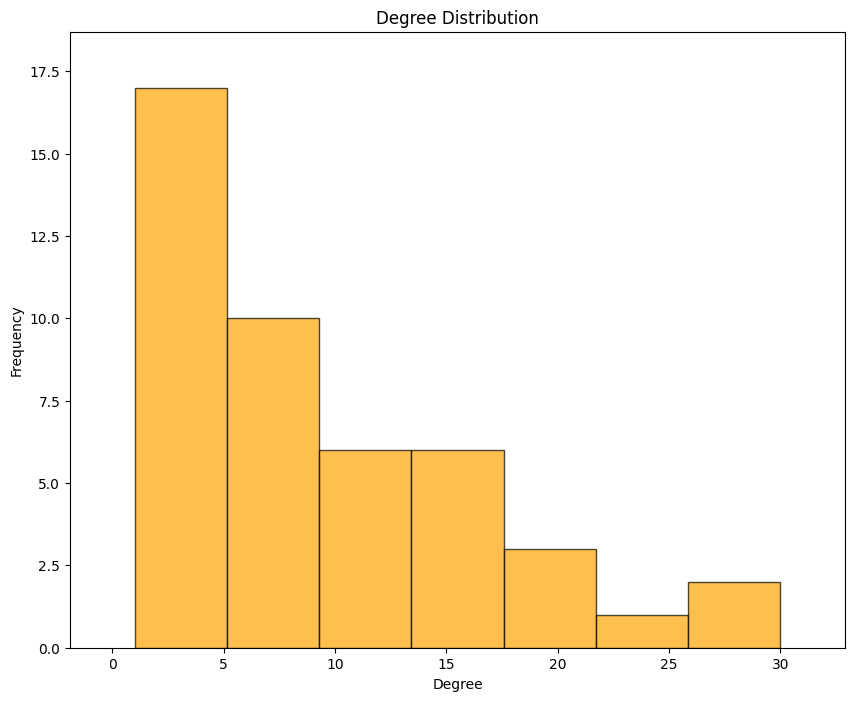

In [ ]:
# Calculate the degree of each node
degrees = [degree for _, degree in G.degree()]

plt.figure(figsize=(10, 8))

# Plot the degree distribution using a histogram
plt.hist(degrees, bins='auto', alpha=0.7, color='orange', edgecolor='black')
plt.xlabel('Degree')
plt.ylabel('Frequency')

plt.title('Degree Distribution')
# plt.grid(True)

# Adjust plot margins
plt.margins(0.1, 0.1)


plt.show()


We see that it is skwed distribution

In [ ]:
from operator import itemgetter

# 4.  Degree Centrality

Centrality measures are used to quantify the importance or influence of individual nodes within a network. They provide insights into the structural significance of nodes based on their connectivity and position within the network.

There are several types of centrality measures, including:

**Degree Centrality**: It measures the number of edges connected to a node. Nodes with higher degree centrality are more connected and influential within the network.

**Betweenness Centrality**: It quantifies the extent to which a node lies on the shortest paths between other pairs of nodes. Nodes with higher betweenness centrality act as bridges or mediators in the network's information flow.

**Closeness Centrality**: It measures how close a node is to all other nodes in the network. Nodes with higher closeness centrality can quickly access information from other nodes and have efficient communication.

**betweenness centrality**

In [ ]:
betweenness_dict = nx.betweenness_centrality(G) # Run betweenness centrality
eigenvector_dict = nx.eigenvector_centrality(G) # Run eigenvector centrality

# Assign each to an attribute in your network
nx.set_node_attributes(G, betweenness_dict, 'betweenness')
nx.set_node_attributes(G, eigenvector_dict, 'eigenvector')

The larger the node size, the higher the betweenness centrality of the node, indicating its importance as a bridge in the network.

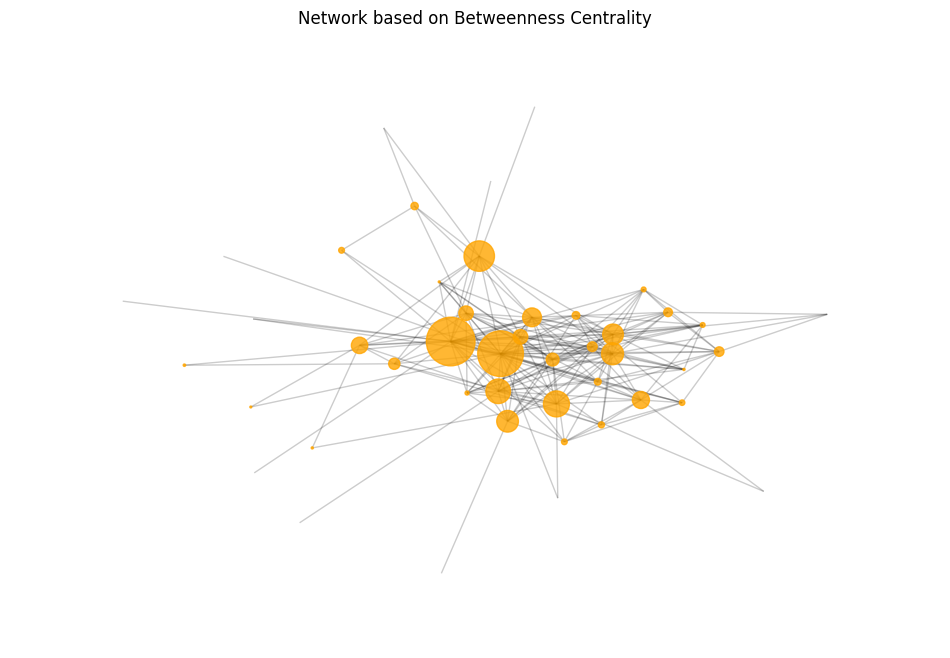

In [ ]:
# # Calculate betweenness centrality
# betweenness_centrality = nx.betweenness_centrality(G)

# # Get the betweenness centrality values as a list
# centrality_values = list(betweenness_centrality.values())

# # Set node size based on betweenness centrality
# node_size = [5000 * centrality for centrality in centrality_values]

# # Draw the network with node size based on betweenness centrality
# pos = nx.spring_layout(G)

# plt.figure(figsize=(12, 8))
# nx.draw_networkx_nodes(G, pos, node_color='orange', node_size=node_size, alpha=0.8)
# # Draw edges
# nx.draw_networkx_edges(G, pos, alpha=0.2)

# plt.title("Network based on Betweenness Centrality")

# # remove a frame
# plt.axis('off')

# # Adjust plot margins
# plt.margins(0.1, 0.1)

# plt.show()


below I added to the code a seed = 41 so every time we run the code, the graph looks the same, and the part in which 5 nodes with the highest betweenness centrality are labelled

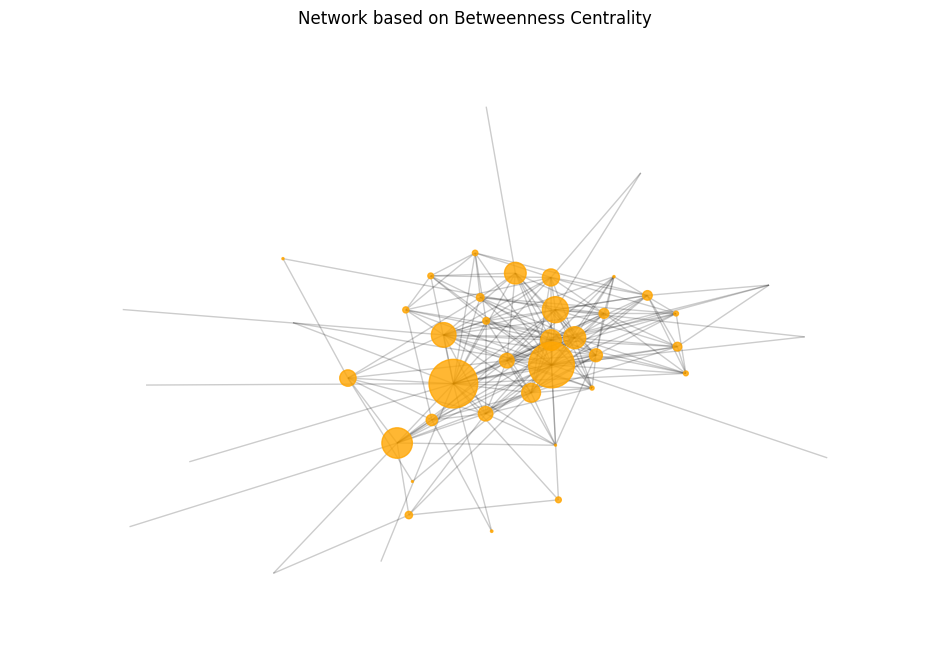

In [ ]:
#seed

seed = 41

# Calculate betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)

# Get the betweenness centrality values as a list
centrality_values = list(betweenness_centrality.values())

# Set node size based on betweenness centrality
node_size = [5000 * centrality for centrality in centrality_values]

# Draw the network with node size based on betweenness centrality
pos = nx.spring_layout(G, seed=seed)

plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G, pos, node_color='orange', node_size=node_size, alpha=0.8)
# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.2)

plt.title("Network based on Betweenness Centrality")


# Add labels for the 5 biggest nodes
# biggest_nodes = sorted(G.nodes(), key=lambda x: betweenness_centrality[x], reverse=True)[:5]
# node_labels = {node: node for node in biggest_nodes}
# nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8, font_color='black')


# remove a frame
plt.axis('off')

# Adjust plot margins
plt.margins(0.1, 0.1)

plt.show()

**Degree Centrality**

In [ ]:
# Calculate degree centrality
degree_centrality = nx.degree_centrality(G)

In [ ]:
degree_centrality_df = pd.DataFrame.from_dict(degree_centrality, orient='index')

In [ ]:
degree_centrality_df.mean()


0    0.208081
dtype: float64

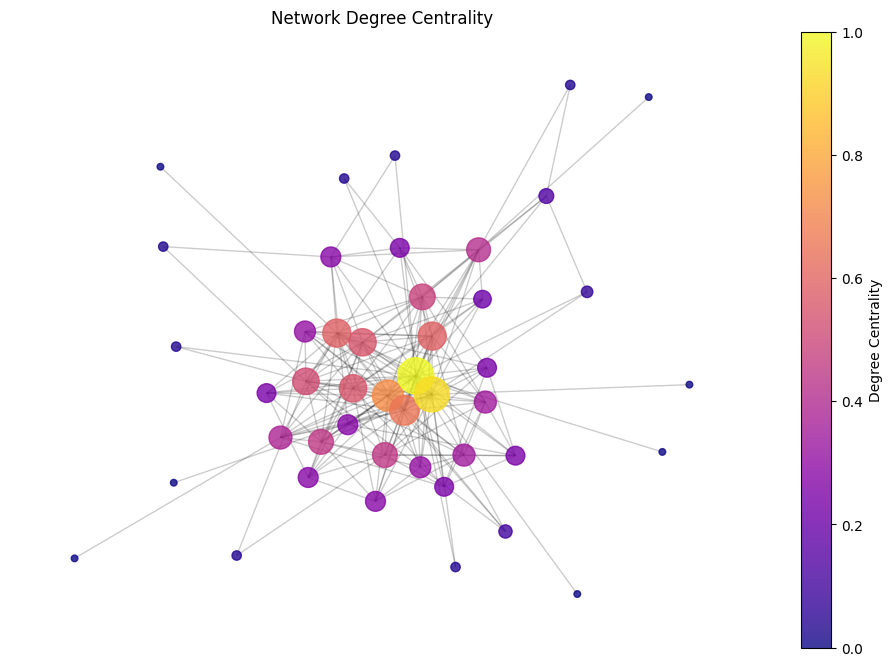

In [ ]:
# # Get the degree centrality values as a list
# centrality_values = list(degree_centrality.values())

# # Normalize the centrality values to the range [0, 1]
# min_centrality = min(centrality_values)
# max_centrality = max(centrality_values)
# normalized_centrality = [(c - min_centrality) / (max_centrality - min_centrality) for c in centrality_values]

# # Set node size based on degree centrality
# node_size = [1000 * centrality for centrality in centrality_values]

# # Draw the network with node color based on degree centrality
# pos = nx.spring_layout(G)

# plt.figure(figsize=(12, 8))
# nodes = nx.draw_networkx_nodes(G, pos, node_color=normalized_centrality, cmap='plasma', node_size=node_size, alpha=0.8)
# # Draw edges
# nx.draw_networkx_edges(G, pos, alpha=0.2)

# plt.title("Network Degree Centrality")
# plt.colorbar(nodes, label='Degree Centrality')

# # remove a frame
# plt.axis('off')

# plt.show()


below I added a seed = 19 so every time we run the code, the graph looks the same, and the part in which 5 nodes with the highest centrality are labelled

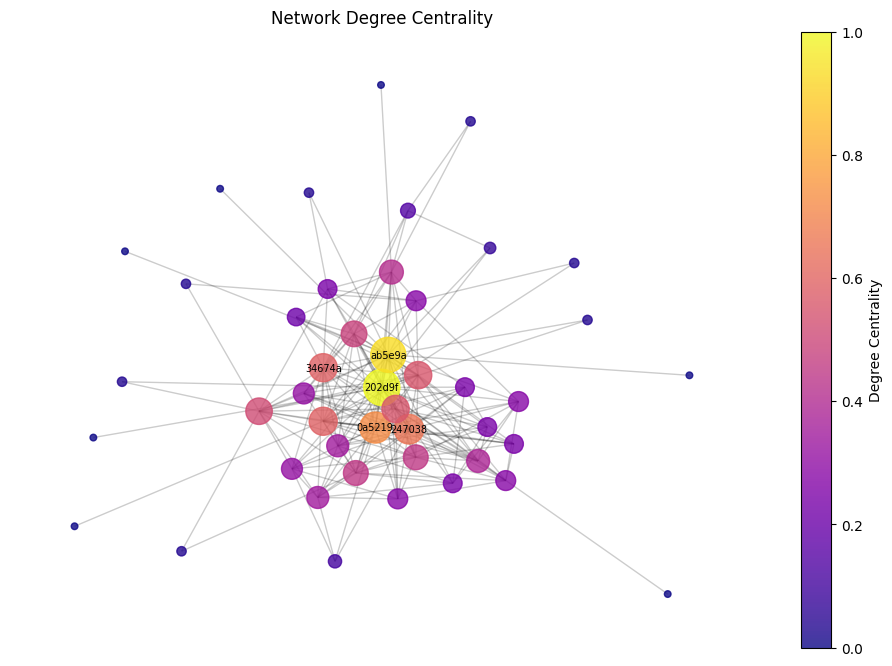

In [ ]:
# seed
seed = 19

# Get the degree centrality values as a list
centrality_values = list(degree_centrality.values())

# Normalize the centrality values to the range [0, 1]
min_centrality = min(centrality_values)
max_centrality = max(centrality_values)
normalized_centrality = [(c - min_centrality) / (max_centrality - min_centrality) for c in centrality_values]

# Set node size based on degree centrality
node_size = [1000 * centrality for centrality in centrality_values]

# Draw the network with node color based on degree centrality
pos = nx.spring_layout(G, seed=seed)

plt.figure(figsize=(12, 8))
nodes = nx.draw_networkx_nodes(G, pos, node_color=normalized_centrality, cmap='plasma', node_size=node_size, alpha=0.8)
# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.2)

plt.title("Network Degree Centrality")
plt.colorbar(nodes, label='Degree Centrality')

# Add labels for the 5 biggest nodes
biggest_nodes = sorted(G.nodes(), key=lambda x: G.degree(x), reverse=True)[:5]
node_labels = {node: node for node in biggest_nodes}
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=7, font_color='black')

# remove a frame
plt.axis('off')

plt.show()

In [ ]:
import matplotlib.lines as mlines
import matplotlib.cm as cm

<ipython-input-105-8c0a7359f478>:27: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(cm.ScalarMappable(cmap=plt.cm.plasma), ticks=[0, 0.2, 0.4, 0.6, 0.8, 1], aspect=40)


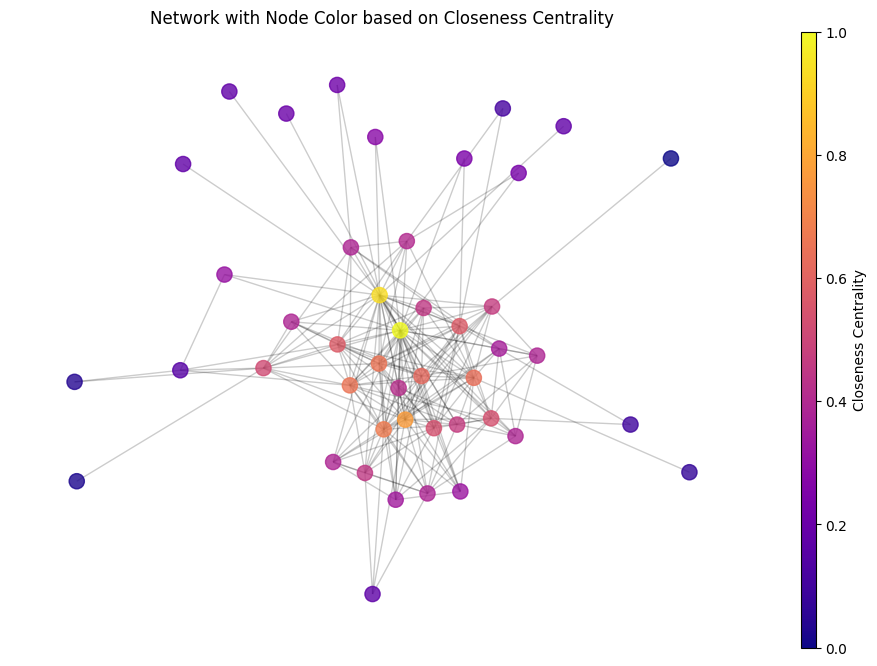

In [ ]:
# # Calculate closeness centrality
# closeness_centrality = nx.closeness_centrality(G)

# # Get the closeness centrality values as a list
# centrality_values = list(closeness_centrality.values())

# # Normalize the centrality values to the range [0, 1]
# min_centrality = min(centrality_values)
# max_centrality = max(centrality_values)
# normalized_centrality = [(c - min_centrality) / (max_centrality - min_centrality) for c in centrality_values]

# # Set node color based on closeness centrality
# node_colors = [plt.cm.plasma(c) for c in normalized_centrality]

# # Draw the network with node color based on closeness centrality
# pos = nx.spring_layout(G)

# plt.figure(figsize=(12, 8))
# nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=120, alpha=0.8)
# # Draw edges
# nx.draw_networkx_edges(G, pos, alpha=0.2)

# plt.title("Network with Node Color based on Closeness Centrality")

# # Create a colorbar legend

# cbar = plt.colorbar(cm.ScalarMappable(cmap=plt.cm.plasma), ticks=[0, 0.2, 0.4, 0.6, 0.8, 1], aspect=40)
# cbar.set_label('Closeness Centrality')

# # remove a frame
# plt.axis('off')

# plt.show()



below I added a seed = 60 so every time we run the code, the graph looks the same, and the part in which 5 nodes with the highest closeness centrality are labelled

<ipython-input-176-5b8ed9bb5ea8>:35: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(cm.ScalarMappable(cmap=plt.cm.plasma), ticks=[0, 0.2, 0.4, 0.6, 0.8, 1], aspect=40)


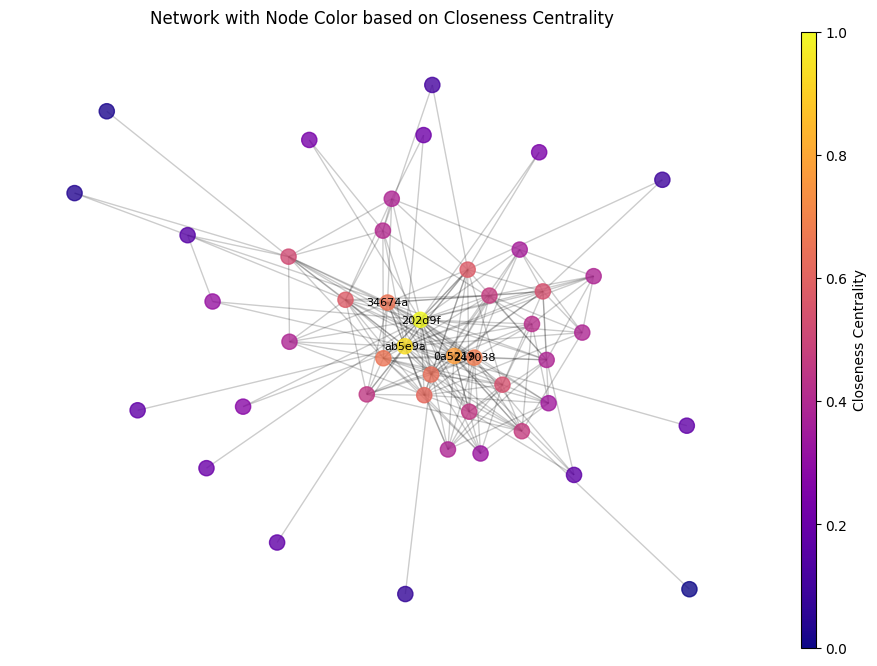

In [ ]:
# Calculate closeness centrality
closeness_centrality = nx.closeness_centrality(G)

# Get the closeness centrality values as a list
centrality_values = list(closeness_centrality.values())

# Normalize the centrality values to the range [0, 1]
min_centrality = min(centrality_values)
max_centrality = max(centrality_values)
normalized_centrality = [(c - min_centrality) / (max_centrality - min_centrality) for c in centrality_values]

# Set node color based on closeness centrality
node_colors = [plt.cm.plasma(c) for c in normalized_centrality]

seed = 60  # Set a fixed seed value

# Draw the network with node color based on closeness centrality
pos = nx.spring_layout(G, seed=seed)

plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=120, alpha=0.8)
# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.2)

plt.title("Network with Node Color based on Closeness Centrality")


# Add labels for top 5 central nodes
top_central_nodes = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
node_labels = {node: node for node, _ in top_central_nodes}
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8, font_color='black')

# Create a colorbar legend

cbar = plt.colorbar(cm.ScalarMappable(cmap=plt.cm.plasma), ticks=[0, 0.2, 0.4, 0.6, 0.8, 1], aspect=40)
cbar.set_label('Closeness Centrality')

# remove a frame
plt.axis('off')

plt.show()



# 4. Modularity

Modularity is a measure of relative density in your network: a community (called a module or modularity class) has high density relative to other nodes within its module but low density with those outside. Modularity gives you an overall score of how fractious your network is, and that score can be used to partition the network and return the individual communities.

In [ ]:
from networkx.algorithms import community #This part of networkx, for community detection, needs to be imported separately.

In [ ]:
communities = community.greedy_modularity_communities(G)

In [ ]:
modularity_dict = {} # Create a blank dictionary
for i,c in enumerate(communities): # Loop through the list of communities, keeping track of the number for the community
    for name in c: # Loop through each person in a community
        modularity_dict[name] = i # Create an entry in the dictionary for the person, where the value is which group they belong to.

# Now add modularity information like we did the other metrics
nx.set_node_attributes(G, modularity_dict, 'modularity')

In [ ]:
# First get a list of just the nodes in that class
class0 = [n for n in G.nodes() if G.nodes[n]['modularity'] == 0]

# Then create a dictionary of the eigenvector centralities of those nodes
class0_eigenvector = {n:G.nodes[n]['eigenvector'] for n in class0}

# Then sort that dictionary and print the first 5 results
class0_sorted_by_eigenvector = sorted(class0_eigenvector.items(), key=itemgetter(1), reverse=True)

print("Modularity Class 0 Sorted by Eigenvector Centrality:")
for node in class0_sorted_by_eigenvector[:5]:
    print("Name:", node[0], "| Eigenvector Centrality:", node[1])

Modularity Class 0 Sorted by Eigenvector Centrality:
Name: 0a5219 | Eigenvector Centrality: 0.28285269872226504
Name: 247038 | Eigenvector Centrality: 0.2542164325177304
Name: 25e301 | Eigenvector Centrality: 0.24070018514226818
Name: 58a2a8 | Eigenvector Centrality: 0.23594863153970183
Name: af0ed3 | Eigenvector Centrality: 0.19486341390699433


In [ ]:
for i,c in enumerate(communities): # Loop through the list of communities
    if len(c) > 2: # Filter out modularity classes with 2 or fewer nodes
        print('Class '+str(i)+':', list(c)) # Print out the classes and their members

Class 0: ['', 'cc548f', '0a5219', '732ccc', 'b551bf', 'a1aadf', '25e301', '656532', 'af0ed3', '3c8058', '247038', 'be7326', '58a2a8', 'e5df29', '8582e9']
Class 1: ['5ea7c8', 'd6dd1f', 'b4f4af', '64ce90', 'ea9a55', 'a11cd8', 'ce8fcd', '34674a', '49bf21', '78f822', '3e9754', '6bc185']
Class 2: ['683466', 'c5e3a5', '4f6d6a', '5a38d6', '4ed170', '202d9f', '0647cf', 'd9b543', 'a598d0', '7e684f', 'acf59e']
Class 3: ['ebd379', '89c3b5', '39dfef', 'a210f8', 'ecc5ab', 'bad55a', 'ab5e9a']


<ipython-input-142-ca7ff133e35e>:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('plasma', max(node_colors) + 1)
<ipython-input-142-ca7ff133e35e>:16: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=range(max(node_colors)+1))


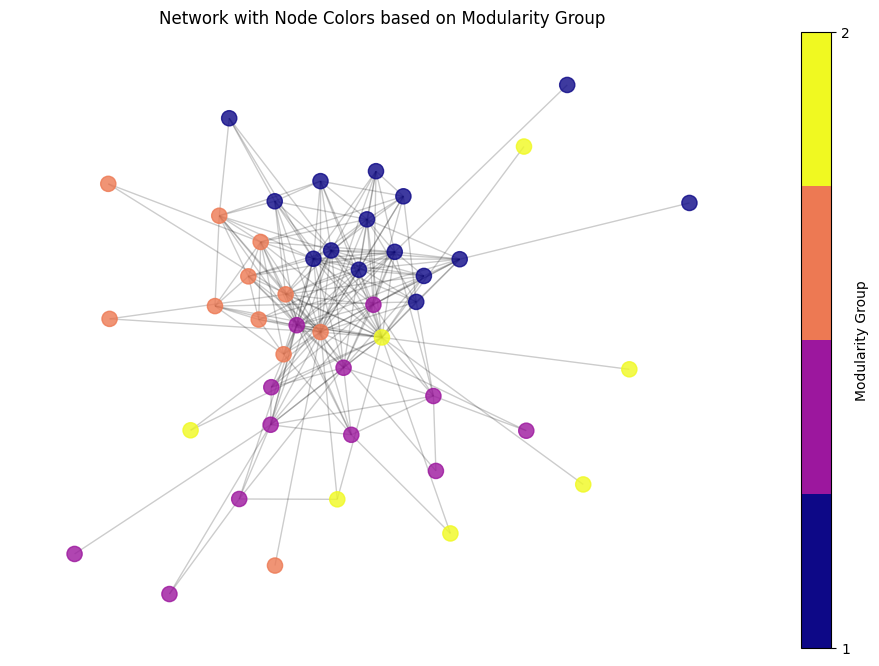

In [ ]:
seed = 50  # Set a fixed seed value
pos = nx.spring_layout(G, seed=seed)   # Choose an appropriate layout for the network
node_colors = [G.nodes[n]['modularity'] for n in G.nodes()]  # Get the modularity group for each node

plt.figure(figsize=(12, 8))


nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap='plasma', node_size=120, alpha=0.8)
# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.2)

# Create a colorbar legend
cmap = plt.cm.get_cmap('plasma', max(node_colors) + 1)
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])
cbar = plt.colorbar(sm, ticks=range(max(node_colors)+1))
cbar.set_ticklabels(range(1, max(node_colors) + 2))
cbar.set_label('Modularity Group')

plt.title("Network with Node Colors based on Modularity Group")

# remove a frame
plt.axis('off')

plt.show()


# 5. Shortest Path - MEH I THINK IT WILL NOT WORK


Analyzing the path lengths helps to understand the efficiency of information flow or the connectedness of nodes.

In [ ]:
avg_shortest_path = nx.average_shortest_path_length(G)
print("Average shortest path length:", avg_shortest_path)


Average shortest path length: 2.085858585858586


In [ ]:
nx.diameter(G)

5

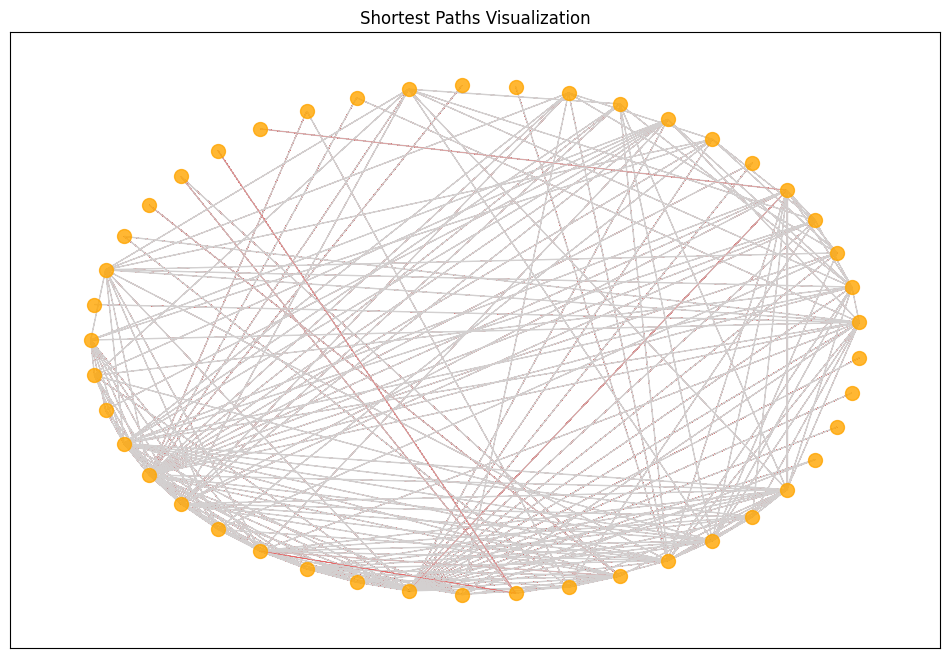

In [ ]:
pos = nx.shell_layout(G)

plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G, pos, node_color='orange', node_size=100, alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.2)

for source, paths in shortest_path_lengths.items():
    for target, length in paths.items():
        if source != target:  # Exclude self-loops
            shortest_path = nx.shortest_path(G, source=source, target=target)
            shortest_path_edges = [(shortest_path[i], shortest_path[i + 1]) for i in range(len(shortest_path) - 1)]
            edge_colors = ['red' if edge in shortest_path_edges else 'lightgray' for edge in G.edges()]
            nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color=edge_colors, width=0.2)

plt.title("Shortest Paths Visualization")
plt.show()